# Some general ideas related to game theory

## Poker Problem 

Kuhn Poker: 1,2,3 -> 

Two pleyer
$$a_{}$$

## Adversarial Generation of Short Prompts for Improving Feedback Quality

**Motivation**

User feedback (reviews, evaluations, surveys) is often affected by cognitive biases, emotional tone, and low informational density. Respondents tend to provide vague, emotionally charged, or socially biased answers, which reduces the usefulness of feedback for decision-making and analysis. This problem is especially pronounced in educational evaluations, product reviews, and employee assessments.


How can short textual prompts be adaptively generated to maximize the information content and reduce bias in customer feedback, under adversarial evaluation?

feedback quality metrics
- Information content I(r) (number of distinct product aspects mentioned, or entropy of aspect distribution, or coverage of predefined aspect set)
- Bias metric B(r) (sentiment extremeness (absolute sentiment score), demographic skew (if groups exist), lexical subjectivity score.)
- Utility U(r) (Human usefulness. Collect later via human ratings 1–5. At the beginning, can be ignored)

GAME:
Generator (G) produces a short prompt p, Evaluator (E) evaluates the resulting feedback r.
G: finite set of prompt types (templates); E: fixed scoring function (at first)

Payoff: $u_{G}​(p)=\alpha I(r)−\beta B(r)$
Evaluator payoff: $uE​(p)=−uG​(p)$ -- this is for now a zero-sum game

The game is between a Prompt Generator and an Evaluator of feedback quality, where the generator tries to elicit informative, low-bias feedback, and the evaluator penalizes bias and low information.

BASELINE PIPELINE:
- Create a small prompt set - pure strategies
- Collect responses (may simulate using LLM)
- NLP analysis: extract aspects (rule-based or simple classifier), compute sentiment score.

payoff matrix

Now: eliminate dominated prompts, compute mixed strategies, identify equilibrium distributions.

FURTHER:
adversarial learning
- Parameterize the prompt - Instead of fixed templates, represent prompt as (length,specificity,number of constraints,presence of examples) -> vector $\theta$
- Train generator, using RL (action = generate prompt parameters, reward = $u_{G}$, environment = evaluator + NLP pipeline.)
- 

comparison of prompts before and after optimization, statistical improvement in I and reduction in B, robustness analysis across datasets.

## Adversarial Generation of Short Prompts for Improving Feedback Quality

customer feedback in textual form

$$R=\{all-possible-feedback-texts\}$$

$$P=\{all possible short prompts\}$$

Given a prompt $p\in P$, the user (environment) generates a feedback text:

$$r∼P(⋅∣p),r\in R$$

The distribution is unknown and stochastic

In [1]:
from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()
SECRET_KEY = os.getenv("OPEN_API_KEY")

PROMPTS = [
    "What did you like about the product?",
    "What problems did you face while using the product?",
    "Please describe your experience with the product.",
    "What should we improve in the product?",
    "How satisfied are you with the product and why?"
]

client = OpenAI(api_key=SECRET_KEY)

def generate_feedback(prompt):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a customer giving honest feedback."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.9, # may be try variate temperature
        max_tokens=120
    )
    return response.choices[0].message.content



Let $A=\{ a_{1}, ...,a_{k} \}$ be a predefined set of product aspects.

Define an aspect extraction function: $\phi :R\rightarrow 2^{A}$

Information content: $I(r)=∣\phi (r)∣$

Lexical divercity:

$$I(r) = \frac{unique tokens}{total tokens}$$

DEFINE BETTER FUNCTION LATER!

Bias metric:

$$B(r)=|s(r)|$$

Where 
$s(r)\in [−1,1] $ - sentiment polarity score

In [2]:
import re
from textblob import TextBlob


def information_metric(text):
    tokens = re.findall(r"\w+", text.lower())
    if len(tokens) == 0:
        return 0.0
    return len(set(tokens)) / len(tokens)

def bias_metric(text):
    sentiment = TextBlob(text).sentiment.polarity
    return abs(sentiment)

Empirical expectation (Monte Carlo)

Since feedback is stochastic, we work with expectations.

$$E[B∣p]=E_{r∼P(⋅∣p)}​[B(r)]$$
$$E[I∣p]=E_{r∼P(⋅∣p)}​[I(r)]$$


In [3]:
import numpy as np

def estimate_expectations(prompt, n_samples=10):
    infos, biases = [], []

    for i in range(n_samples):
        r = generate_feedback(prompt)
        infos.append(information_metric(r))
        biases.append(bias_metric(r))

    return np.mean(infos), np.mean(biases)

**Payoff function (parametrized)**

Player G (Generator) chooses prompt p

Player E (Evaluator) enforces quality constraints

Strategy spaces

Generator strategies:

$p\in P$

Evaluator strategies:

$$\lambda = (\alpha, \beta)\in \mathbb{R}_{+}^{2}$$
	​
Evaluator controls the penalty weights.

Generator payoff:

$$u_G​(p,λ)=αE[I∣p]−βE[B∣p]$$

Evaluator payoff:

$$u_E​(p,λ)=−u_G​(p,λ)$$

**Static game with finite strategies:**

Finite prompts: $P={p_1​,…,p_n​}$

Define payoff: $U_i​=αE[I∣p_i​]−βE[B∣p_i​]$

$p_{i}$ is dominated by $p_{j}$ if $U_j​≥U_i​$. Dominated prompts can be eliminated.

We seek a minimax equillibrium $\max_{\pi} \min_{\alpha, \beta} U_{G}(\pi, \lambda)$


THINK ABOUT LATER: Dynamic learning formulation, 
Let prompts be generated by parameters: $p=g(\theta),\theta \in \mathbb{R}^{d}$

Constraints on parameters: $\alpha+\beta=1$, $u_{E}​=−u_{G}​−c(\beta)$ ($c(\beta)=\gamma \beta^{2}$)

In [4]:
def payoff(prompt, alpha=1.0, beta=1.0, n_samples=10):
    I_hat, B_hat = estimate_expectations(prompt, n_samples)
    return alpha * I_hat - beta * B_hat

Playing the game (best response)

The generator chooses the best prompt given evaluator parameters.

THINK ABOUT LATER: Transformer as Prompt Generator

Prompt as a function of parameters, instead of choosing a prompt directly, define: $p_{\theta} =G_{\theta}​(z)$

In [ ]:
def best_prompt(prompts, alpha, beta):
    scores = {}
    for p in prompts:
        scores[p] = payoff(p, alpha, beta)
    return max(scores, key=scores.get), scores

best, all_scores = best_prompt(PROMPTS, alpha=1.0, beta=0.7)

print("Best prompt:", best)
for p, s in all_scores.items():
    print(f"{p[:40]}... -> {s:.4f}")

# BETAS = [0.2, 0.5, 1.0, 2.0]

# for beta in BETAS:
#     best, _ = best_prompt(PROMPTS, alpha=1.0, beta=beta)
#     print(f"beta={beta:.1f} -> best prompt: {best}")

Best prompt: What problems did you face while using the product?
What did you like about the product?... -> 0.5290
What problems did you face while using t... -> 0.7067
Please describe your experience with the... -> 0.6287
What should we improve in the product?... -> 0.6033
How satisfied are you with the product a... -> 0.5855


: 

## Improved Game

- improve calculation of functions I(r) and B(r)
- 



I(r) calculation: $A$ - set of aspects, $R$ - response space

$$aspects: R -> 2^{A}$$

$I_{a}(r) = \frac{|aspects(r)|}{|A|}$

$I_{total} = \sqrt{I_{aspects}^{2} * w_{1} + I_{suggestion}^{2} * w_{2} + I_{general-ner}^{2} * w_{3}}$

bias == упередженість

In [ ]:
from openai import OpenAI
from dotenv import load_dotenv
import os
import re
from textblob import TextBlob
import spacy 
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nlp = spacy.load("en_core_web_sm")

load_dotenv()
SECRET_KEY = os.getenv("OPEN_API_KEY")

PROMPTS = [
    "What did you like about the product?",
    "What problems did you face while using the product?",
    "Please describe your experience with the product.",
    "What should we improve in the product?",
    "How satisfied are you with the product and why?"
]

client = OpenAI(api_key=SECRET_KEY)

def generate_feedback(prompt):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a customer giving honest feedback."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.9, # may be try variate temperature
        max_tokens=120
    )
    return response.choices[0].message.content


# utility functions definition
ASPECTS = {
    "price": ["price", "cost", "expensive", "cheap"],
    "delivery": ["delivery", "shipping", "arrived"],
    "quality": ["quality", "broken", "durable"],
    "support": ["support", "service", "help"],
    "usability": ["easy", "difficult", "interface", "ui"],
    "performance": ["fast", "slow", "lag"]
}
SUGGESTION_PATTERNS = [
    "should", "could", "recommend", "improve", "add", "fix" # "it would be better"
]
EMOTION_WORDS = {"amazing", "terrible", "horrible", "fantastic", "worst"}

def information_metric_aspect(text):
    text = text.lower()
    doc = nlp(text)
    lemmas = {token.lemma_ for token in doc if token.is_alpha} # lemmatization

    found = set()
    
    for aspect, keywords in ASPECTS.items():
        keyword_lemmas = {nlp(k)[0].lemma_ for k in keywords}
        if lemmas.intersection(keyword_lemmas):
            found.add(aspect)
    
    return len(found) / len(lemmas), found


def information_metric_actionability(text):
    text = text.lower()
    doc = nlp(text)
    lemmas = {t.lemma_ for t in doc if t.is_alpha}

    found = []
    suggestion_lemmas = {nlp(s)[0].lemma_ for s in SUGGESTION_PATTERNS}
    for l in suggestion_lemmas:
        if l in lemmas:
            found.append(l)
    
    return len(found)/len(suggestion_lemmas), found

# number of distinct entities mentioned
def information_metric_ner(text):
    doc = nlp(text)
    unique = set(e.text.lower() for e in doc.ents)

    return len(unique) / len(doc) if doc else 0, [e.text for e in doc.ents]

def information_metric_combined(text):
    n = 2
    # w = [0.4, 0.3, 0.3]
    aspect_metric, _ = information_metric_aspect(text)
    actionability_metric, _ = information_metric_actionability(text)
    ner_metric, _ = information_metric_ner(text)

    return ((aspect_metric**n) + (actionability_metric**n) + (ner_metric**n))**(1/n)


def bias_metric_ner(text):
    doc = nlp(text.lower())
    lemmas = {t.lemma_ for t in doc if t.is_alpha}

    found = []
    emotion_lemmas = {nlp(s)[0].lemma_ for s in EMOTION_WORDS}
    for l in emotion_lemmas:
        if l in lemmas:
            found.append(l)
    
    return len(found) / len(emotion_lemmas), found

nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()
def bias_sentiment_intencity(text):
    score = sia.polarity_scores(text)["compound"]
    return abs(score)


def bias_metric_combined(text):
    n = 2
    # w = [0.5, 0.5]
    ner, _ = bias_metric_ner(text)
    polarity = bias_sentiment_intencity(text)

    return ((ner**n) + (polarity**n))**(1/n)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vmelnyk2\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
test_response = """"Hey there!
I bought the EchoHome Smart Lamp about three weeks ago, mostly because I was tired of harsh overhead lighting while reading at night. I wasn’t sure what to expect — sometimes “smart” gadgets feel more complicated than they’re worth — but this one? Totally different story.
Setting it up took maybe five minutes with the app, and since then it’s become my favorite part of my evening routine. I love that I can adjust the color temperature from bright white for work to a soft amber for winding down. The sunset fade-out feature actually helps me fall asleep — no joke!
My cat is also weirdly obsessed with it (she sits under it like it’s her personal sun), so that’s an unexpected bonus. 😸
If I had one tiny wish: I’d love a physical remote control option for when my phone isn’t nearby. But honestly, it’s such a small thing compared to how much I enjoy using it.
Thanks for making a product that feels both thoughtful and genuinely useful. It’s the little things that make a home cozy, right?
Cheers, Alex"""

print(information_metric_aspect(test_response))
print(information_metric_actionability(test_response))
print(information_metric_ner(test_response))
print(information_metric_combined(test_response))

print(bias_metric_ner(test_response))
print(bias_sentiment_intencity(test_response))
print(bias_metric_combined(test_response))

print(f"Total score of feedback: {information_metric_combined(test_response) - bias_metric_combined(test_response)}")


(0.007462686567164179, {'support'})
(0.0, [])
(0.022222222222222223, ['about three weeks ago', 'night', 'five minutes', 'evening', 'one'])
0.023441818429754117
(0.0, [])
0.9958
0.7041369327055641
Total score of feedback: -0.68069511427581


In [2]:
import numpy as np

PROMPTS = [
    "What did you like about the product?",
    "What problems did you face while using the product?",
    "Please describe your experience with the product.",
    "What should we improve in the product?",
    "How satisfied are you with the product and why?"
]

def estimate_expectations(prompt, n_samples=10):
    infos, biases = [], []

    for i in range(n_samples):
        r = generate_feedback(prompt)
        infos.append(information_metric_combined(r))
        biases.append(bias_metric_combined(r))

    return np.mean(infos), np.mean(biases)

def payoff(prompt, alpha=1.0, beta=1.0, n_samples=10):
    I_hat, B_hat = estimate_expectations(prompt, n_samples)
    return alpha * I_hat - beta * B_hat


def best_prompt(prompts, alpha, beta):
    scores = {}
    for p in prompts:
        scores[p] = payoff(p, alpha, beta)
    return max(scores, key=scores.get), scores

best, all_scores = best_prompt(PROMPTS, alpha=1.0, beta=0.7)

print("Best prompt:", best)
for p, s in all_scores.items():
    print(f"{p[:40]}... -> {s:.4f}")

Best prompt: What problems did you face while using the product?
What did you like about the product?... -> -0.5722
What problems did you face while using t... -> -0.2790
Please describe your experience with the... -> -0.5354
What should we improve in the product?... -> -0.3091
How satisfied are you with the product a... -> -0.4525


## Generating prompts from the set of parameters

Should we try transformer-based prompt generator? (think about it later, may be as an option for later)

Embedding-space parametrization: embed prompts using word2vec, then decode using nearest prompt in embedding space for given set of parametes. (?)


For now:
- parameter vector: $\theta = (tone, focus, specificity, length, framing)$


In [ ]:
TONES = ["neutral", "encouraging", "critical"]
FOCUS = ["general", "usability", "price", "delivery"]
SPECIFICITY = ["broad", "detailed"]
FRAMING = ["open", "problem-oriented", "improvement-oriented"]

def generate_prompt(theta):
    tone, focus, specificity, length, framing = theta 

    base = "Please provide feedback"
    if focus != "general":
        base += f" about the {focus} of service. "

    if framing == "problem-oriented":
        base += "What problems did you encounter? "
    elif framing == "improvement-oriented":
        base += "What should we improve? "

    if specificity == "detailed":
        base += "Please be as specific as possible. "

    if tone == "encouraging":
        base += "We value your opinion!" 

    elif tone == "critical":
        base += "Be honest and critical!"

    delimiters = {'.', '!', '?'}
    sentences = []
    current_sentence = []
    for char in base:
        current_sentence.append(char)
        if char in delimiters:
            sentences.append(''.join(current_sentence).strip())
            current_sentence = []
            
            if len(sentences) >= length:
                break
    
    if current_sentence and len(sentences) < length:
        sentences.append(''.join(current_sentence).strip())
    
    return ' '.join(sentences[:length])

print(generate_prompt(["encouraging", "usability", "detailed", 6, "problem-oriented"]))

Please provide feedback about the usability of service. What problems did you encounter? Please be as specific as possible. We value your opinion!


## TODO

- may be real scenario of application (online shop) (for VS -> create an endpoint for feedback responses)
- Named entity recognition (nlp topic) for I(r), think B(r) (for Stanislav -> think of more keywords)
- Reinforcement learning (contextual bandit) for players to choose parameters  (-> read articles)
- Dynamic learning formulation, Let prompts be generated by parameters: $p=g(\theta),\theta \in \mathbb{R}^{d}$ (transformers)
- qualatative metrics of approach
- try different variate temperature, as a parameter (?)
- FL (repeatable game? for later)

- Parametrize prompt generation via word vector embeddings (!)

### Parametrize prompt generation via word vector embeddings

t_0, t_1, t_2,....



In [ ]:
import gensim.downloader as api

corpus = api.load('glove-wiki-gigaword-100')

In [2]:
vector = corpus['computer']
print(vector)

[-1.6298e-01  3.0141e-01  5.7978e-01  6.6548e-02  4.5835e-01 -1.5329e-01
  4.3258e-01 -8.9215e-01  5.7747e-01  3.6375e-01  5.6524e-01 -5.6281e-01
  3.5659e-01 -3.6096e-01 -9.9662e-02  5.2753e-01  3.8839e-01  9.6185e-01
  1.8841e-01  3.0741e-01 -8.7842e-01 -3.2442e-01  1.1202e+00  7.5126e-02
  4.2661e-01 -6.0651e-01 -1.3893e-01  4.7862e-02 -4.5158e-01  9.3723e-02
  1.7463e-01  1.0962e+00 -1.0044e+00  6.3889e-02  3.8002e-01  2.1109e-01
 -6.6247e-01 -4.0736e-01  8.9442e-01 -6.0974e-01 -1.8577e-01 -1.9913e-01
 -6.9226e-01 -3.1806e-01 -7.8565e-01  2.3831e-01  1.2992e-01  8.7721e-02
  4.3205e-01 -2.2662e-01  3.1549e-01 -3.1748e-01 -2.4632e-03  1.6615e-01
  4.2358e-01 -1.8087e+00 -3.6699e-01  2.3949e-01  2.5458e+00  3.6111e-01
  3.9486e-02  4.8607e-01 -3.6974e-01  5.7282e-02 -4.9317e-01  2.2765e-01
  7.9966e-01  2.1428e-01  6.9811e-01  1.1262e+00 -1.3526e-01  7.1972e-01
 -9.9605e-04 -2.6842e-01 -8.3038e-01  2.1780e-01  3.4355e-01  3.7731e-01
 -4.0251e-01  3.3124e-01  1.2576e+00 -2.7196e-01 -8

In [3]:
import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    return dot_product / (norm1 * norm2)

similarity = cosine_similarity(corpus['computer'], corpus['laptop'])
print(f"Similarity between 'computer' and 'laptop': {similarity:.4f}")
similarity = cosine_similarity(corpus['computer'], corpus['banana'])
print(f"Similarity between 'computer' and 'banana': {similarity:.4f}")

Similarity between 'computer' and 'laptop': 0.7024
Similarity between 'computer' and 'banana': 0.1213


Vector for prompt: 'What did you like about the product?' -> [ 0.03739825  0.38885877  0.71160495 -0.49684978 -0.47600588]...
Vector for prompt: 'What problems did you face while using the product?' -> [-0.07421871  0.29424903  0.556045   -0.3901159  -0.26465634]...
Vector for prompt: 'Please describe your experience with the product.' -> [-0.35529357  0.25421098  0.5304475  -0.173006   -0.22405037]...
Vector for prompt: 'What should we improve in the product?' -> [-0.00215487  0.2443204   0.4948935  -0.27943227 -0.3097169 ]...
Vector for prompt: 'How satisfied are you with the product and why?' -> [-0.1452837   0.40536967  0.5601141  -0.3920296  -0.3398763 ]...
Vector for prompt: 'What was your first impression when you opened the box?' -> [-0.04402655  0.08546364  0.5823927  -0.36114636 -0.25256744]...
Vector for prompt: 'Does the product look the same in person as it does on our website?' -> [-0.054133    0.14282842  0.56561935 -0.38425714 -0.03604006]...
Vector for prompt: 'How wou

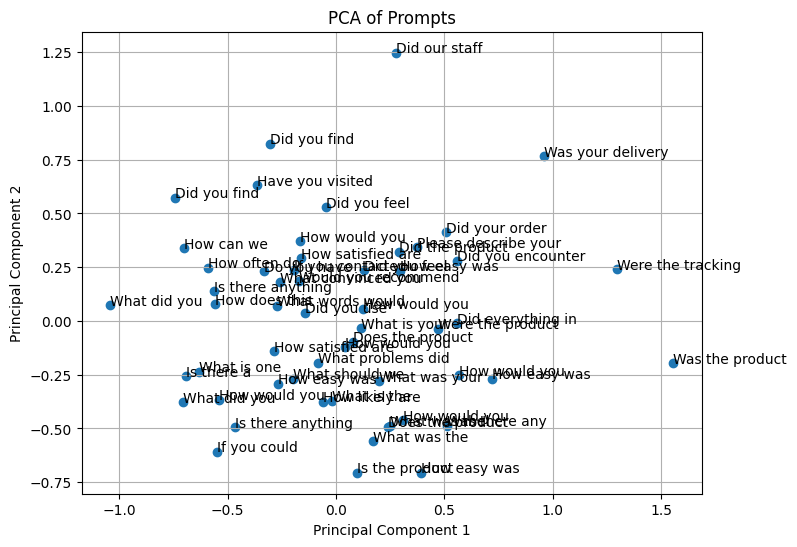

[-1.0, -0.9, -0.8, -0.7000000000000001, -0.6000000000000001, -0.5000000000000001, -0.40000000000000013, -0.30000000000000016, -0.20000000000000018, -0.1000000000000002, -2.220446049250313e-16, 0.09999999999999964, 0.19999999999999973, 0.2999999999999998, 0.3999999999999997, 0.49999999999999956, 0.5999999999999996, 0.6999999999999997, 0.7999999999999996, 0.8999999999999995]
Selected parameter vector: [-0.6000000000000001, 0.3999999999999997], best prompt: How can we make your next shopping experience even better?


In [14]:
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def vectorize_text(text):
    words = word_tokenize(text.lower())
    word_vectors = []
    for word in words:
        if word in corpus:
            word_vectors.append(corpus[word])
    if word_vectors:
        text_vector = np.mean(word_vectors, axis=0)
    else:
        text_vector = np.zeros(corpus.vector_size)
    return text_vector

PROMPTS = [
    "What did you like about the product?",
    "What problems did you face while using the product?",
    "Please describe your experience with the product.",
    "What should we improve in the product?",
    "How satisfied are you with the product and why?",
    "What was your first impression when you opened the box?",
    "Does the product look the same in person as it does on our website?",
    "How would you rate the quality of the materials used?",
    "Is the product performing as you expected it to?",
    "What is your favorite feature of your new purchase?",
    "How does this product compare to others you have tried?",
    "Would you recommend this specific item to a friend?",
    "Did the product size or dimensions meet your needs?",
    "How easy was it to set up or use the product for the first time?",
    "Is there anything about the product that surprised you?",
    "What convinced you to choose this specific item over others?",
    "How often do you find yourself using the product?",
    "If you could change one thing about the product, what would it be?",
    "Does the product offer good value for the price you paid?",
    "How would you describe this product to someone who has never seen it?",
    "Did your order arrive within the expected timeframe?",
    "How would you rate the condition of the packaging upon arrival?",
    "Was the product well-protected during transit?",
    "What did you think of our unboxing experience?",
    "Were the tracking updates helpful throughout the delivery process?",
    "Did you find our shipping costs reasonable?",
    "Was your delivery driver professional and courteous?",
    "How easy was it to open the outer shipping container?",
    "Was there any unnecessary waste in the packaging we used?",
    "Did everything in your order arrive in a single shipment?",
    "How easy was it to find what you were looking for on our site?",
    "Did you encounter any technical issues during the checkout process?",
    "How would you rate the clarity of our product descriptions?",
    "Were the product images helpful in making your decision?",
    "How satisfied are you with the payment options we provide?",
    "Did you feel your personal information was secure while shopping?",
    "How would you rate the speed of our website?",
    "Did you use any discount codes, and if so, did they work correctly?",
    "How easy was it to navigate our shop on your mobile device?",
    "What is one thing we could do to make shopping with us easier?",
    "If you contacted support, how helpful was our team?",
    "How likely are you to shop with us again in the future?",
    "What is the main reason you chose to shop with us today?",
    "Did you feel valued as a customer during your interaction with us?",
    "How can we make your next shopping experience even better?",
    "Have you visited our 'Frequently Asked Questions' page?",
    "Did our staff provide timely responses to your inquiries?",
    "How would you rate your overall satisfaction with our brand?",
    "Did you find our return policy easy to understand?",
    "What words would you use to describe our company to a colleague?",
    "Do you have any additional comments or suggestions for us?",
    "Is there a product you wish we carried that we currently don't?",
    "What was the best part of your experience with us?",
    "What was the most frustrating part of your experience with us?",
    "Is there anything else you’d like us to know about your order?"
]

for prompt in PROMPTS:
    vec = vectorize_text(prompt)
    print(f"Vector for prompt: '{prompt}' -> {vec[:5]}...")

pca = PCA(n_components=2)

prompt_vectors = np.array([vectorize_text(p) for p in PROMPTS])
reduced = pca.fit_transform(prompt_vectors)
for i, prompt in enumerate(PROMPTS):
    print(f"Prompt: '{prompt}' -> PCA: {reduced[i]}")

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1])
for i, prompt in enumerate(PROMPTS):
    plt.annotate(f"{' '.join(prompt.split(' ')[:3])}", (reduced[i, 0], reduced[i, 1]))
plt.title("PCA of Prompts")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()


def distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

def select_prompt(theta):
    best_distance = 1
    best_prompt = None
    for i, prompt in enumerate(PROMPTS):
        d = distance(reduced[i], theta)
        if d < best_distance:
            best_prompt = prompt
            best_distance = d  

    return best_prompt

steps = [i for i in np.arange(-1, 1, 0.1)]
print(steps)

parameter_vector = [np.random.choice(steps), np.random.choice(steps)]
print(f"Selected parameter vector: {parameter_vector}, best prompt: {select_prompt(parameter_vector)}")

In [ ]:
parameters = {0: "tone", 1: "focus", 2: "specificity", 3: "length", 4: "framing"}
vector = [0.9, 0.5, 0.8, 1, 0]